# Problem. Logistic Regression Problem (Non-Convex Smooth)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import topology
import math

In [2]:
from tqdm.notebook import tqdm

In [3]:
import torch

Assume the network size is $n$. In this code, we consider the decentralized logsitic regression problem

$$\min_x J(x) = \frac{1}{n}\sum_{i=1}^n J_i(x) + r(x),$$ 
where $J_i(x) = \mathbb{E}\ln(1 + \exp(-\gamma_i h_i^T x))$, and $r(x) = \sum_{j=1}^d \frac{R x_j^2}{1 + x_j^2}$ is a non-convex regularization term. At each agent/node, we have 

$$J_i(x) = \frac{1}{L}\sum_\ell \ln(1 + \exp(-\gamma_{i,\ell} h_{i,\ell}^T x)).$$

In [4]:
def generate_data_lr(n, N_data, N_feature, W0):
    """
    Data generation
    Args:
        n: number of workers
        N_data: number of data
        N_feature: dimention of the data (or parameter since linear model)
        W0: the true parameter
    returns:
        X: data, from 1 to n
        y: labels
    """
    
    N, M = N_data, N_feature
    
    Nk = N//n   # Nk: the number of samples kept in each agent
    
    X = np.zeros((N, M))
    y = np.zeros((N, 1))    
    
    for k in range(n):
        
        Xk = np.random.randn(Nk, M)
        wk = W0[k,:].reshape(M, 1)
        yk = np.random.rand(Nk, 1) < 1 / (1 + np.exp(-Xk.dot(wk)))
        yk = yk.astype(int)
        
        X[k*Nk:(k+1)*Nk, :] = Xk
        y[k*Nk:(k+1)*Nk] = yk
        
    y = 2*y - 1
    
    return X, y

In [5]:
def data_gen(N, n, d, data_hetero=0.2):
    """
    generate data
    Args:
        N: number of data
        n: number of agents
        d: feature dimention
        data_hetero: mutually add data heterogenety
    """
    np.random.seed(100)

    W0 = np.zeros((n, d))
    ws_reference = np.random.randn(1, d)
    for k in range(n):
        w_0k = np.random.randn(1, d) 
        w_0k = w_0k / np.linalg.norm(w_0k)
        W0[k, :] = ws_reference + data_hetero * w_0k
#         W0[k, :] = ws_reference + data_hetero * np.random.randn(1, d)

    X, y = generate_data_lr(n, N_data = N, N_feature = d, W0 = W0)
    return X, y

To get $x^\star$, we employ classic gradient descent to solve the logsic regression problem. The gradient of $r(w)$ is
$$\nabla r(x) = \left( \frac{2Rx_1}{(1+x_1^2)^2} , \cdots, \frac{2Rx_n}{(1+x_n^2)^2}\right)^T\ .$$
The gradient descent method is: 
$$x_t = x_{t-1} - \mu \nabla J(x_{t-1}) = x_{t-1} - \mu \big(\nabla r(x) - \frac{1}{nL}\sum_k \alpha_k \gamma_k h_k\big),$$ 
where $\alpha_k = \frac{\exp(-\gamma_k h_k^T x_{t-1})}{1 + \exp(-\gamma_k h_k^T x_{t-1})}$.

In [6]:
def lr_full_grad(X, y, w, R):
    """
    calculate the gradient, which is the gradient of J 
    Args:
        X: data sample
        y: label
        w: model parameter
        R: penalty parameter
    returns:
        grad: sample gradient of one node
    """
    
    _, M = X.shape
    
    prob = np.exp(- y * X.dot(w))
    alpha = prob / (1 + prob)
    
    r_grad = 2*R*w/((1+w*w)**2)
    
    grad = r_grad.reshape(M, 1) - np.mean(alpha*y*X, axis = 0).reshape(M, 1)
    
    return grad

In [7]:
def lr_full_grad_dist(X, y, W, R):
    """
    calculate the full gradient for each node
    Args:
        X: data 
        y: labels
        W: collections of parameters of all agents, with n\times d
        R: penalty parameter
    returns:
        G: the full gradient as the composition of all nodes
    """
    N, M = X.shape
    
    # K: number of agents
    K = W.shape[0]
    
    # N_agent: number of data for each agent
    N_agent = N//K    
    
    G = np.zeros((K, M))
    
    for k in range(K):
        
        # find data, label, parameter for each agent
        wk = W[k,:].reshape(M, 1)        
        Xk = X[k*N_agent:(k+1)*N_agent, :]
        yk = y[k*N_agent:(k+1)*N_agent].reshape(N_agent, 1)
        
        
        prob = np.exp(- yk * Xk.dot(wk))
        alpha = prob / (1 + prob)
        
        r_grad = 2*R*wk/((1+wk*wk)**2)

        grad = r_grad.reshape(M, 1) - np.mean(alpha*yk*Xk, axis = 0).reshape(M, 1)
        G[k,:] = grad.T
    
    return G

In [8]:
def lr_stochastic_grad_dist(X,y,W,R,seed,batch=1):
    """
    calculate the stochastic gradient estimator
    Args:
        X,y: data
        W: model parameter
        R: penalty parameter
        seed: random seed for drawing stochastic samples
        batch: batch size, =1 for sgd, > 1 for mini-batch
    """
    N, M = X.shape
    
    # K: number of agents
    K = W.shape[0]
    
    # N_agent: number of data for each agent
    N_agent = N//K    
    
    G = np.zeros((K, M))
    
    np.random.seed(seed = seed)
    
    for k in range(K):
        
        # find data, label, parameter for each agent
        wk = W[k,:].reshape(M, 1)
        idx = np.random.choice(np.arange(k*N_agent, (k+1)*N_agent), size=batch, replace=False)
        Xk = X[idx, :]
        yk = y[idx].reshape(batch, 1)
        
        
        prob = np.exp(- yk * Xk.dot(wk))
        alpha = prob / (1 + prob)
        
        # r_grad = 2*R*np.sum(wk/((1+wk*wk)*(1+wk*wk)))
        r_grad = 2*R*wk/((1+wk*wk)**2)

        grad = r_grad.reshape(M, 1) - np.mean(alpha*yk*Xk, axis = 0).reshape(M, 1)
        G[k,:] = grad.T
    
    return G

In [9]:
def train_dsgd_static(n, d, R, X, y, maxite, mu, mu_decay = 0.4, period = 100, seed0 = 1, batch = 1, method =None):
    """
    training procedure for DSGD with static topology
    Args:
        n: number of agents
        d: dimention of the features
        R: penalty method
        X: dataset of all agents
        y: labels
        maxite: maximum iterations
        mu: initial stepsize
        mu_decay: decay of stepsize
        period: occasion of decay happens 
        seed0: stochastic random seed
        batch: batch size
        method: different algorithms, ring, grid, etc
    """
    W = np.zeros((n,d))
    Y = np.zeros((n,d))
    Gp = np.zeros((n, d))
    
    grad_record = np.zeros((maxite, 1))

    if method == 'ExpGraph':
        A = topology.ExponentialGraph(n)
    elif method == 'RingGraph':
        A = topology.RingGraph(n)
    elif method == 'GridGraph':
        A = topology.GridGraph(n)
    elif method == 'FullyConnectedGraph':
        A = topology.FullyConnectedGraph(n)
    elif method == 'StarGraph':
        A = topology.StarGraph(n)
        
    for ite in range(maxite):
        if (ite+1)%period == 0:
            mu = mu*mu_decay
    
        # record gradient norm
        w_ave = np.mean(W, axis=0).reshape(d, 1)
        g = lr_full_grad(X, y, w_ave, R)
        grad_record[ite] = np.linalg.norm(g,2)

        G = lr_stochastic_grad_dist(X, y, W, R, seed=ite*seed0, batch = batch)
        W = A@(W - mu*G)

    return grad_record

In [10]:
def train_dsgt_static(n, d, R, X, y, maxite, mu, mu_decay = 0.4, period = 100, seed0 = 1, batch = 1, method =None):
    """
    training procedure for DSGT with static topology
    Args:
        n: number of agents
        d: dimention of the features
        R: penalty method
        X: dataset of all agents
        y: labels
        maxite: maximum iterations
        mu: initial stepsize
        mu_decay: decay of stepsize
        period: occasion of decay happens 
        seed0: stochastic random seed
        batch: batch size
        method: different algorithms, ring, grid, etc
    """
    W = np.zeros((n,d))
    Y = np.zeros((n,d))
    Gp = np.zeros((n, d))
    
    grad_record = np.zeros((maxite, 1))

    if method == 'ExpGraph':
        A = topology.ExponentialGraph(n)
    elif method == 'RingGraph':
        A = topology.RingGraph(n)
    elif method == 'GridGraph':
        A = topology.GridGraph(n)
    elif method == 'FullyConnectedGraph':
        A = topology.FullyConnectedGraph(n)
    elif method == 'StarGraph':
        A = topology.StarGraph(n)
        
    for ite in range(maxite):
        if (ite+1)%period == 0:
            mu = mu*mu_decay
        if ite == 0:
            G = lr_stochastic_grad_dist(X, y, W, R, seed=ite*seed0, batch = batch)
            Y = G.copy()
            Gp = G.copy()
        else:
            W = A.dot(W - mu*Y)
            G = lr_stochastic_grad_dist(X, y, W, R, seed=ite*seed0, batch = batch)
            Y = A @ Y + G - Gp
            Gp = G.copy()
        w_ave = np.mean(W, axis=0).reshape(d, 1)
        g = lr_full_grad(X, y, w_ave, R)
        grad_record[ite] = np.linalg.norm(g,2)

    return grad_record

In [11]:
def train_dsgd_dynamic(n, d, R, X, y, maxite, mu, mu_decay = 0.4, period = 100, seed0 = 1, batch = 1, method =None):
    """
    training procedure for DSGD with dynamic topology
    Args:
        n: number of agents
        d: dimention of the features
        R: penalty method
        X: dataset of all agents
        y: labels
        maxite: maximum iterations
        mu: initial stepsize
        mu_decay: decay of stepsize
        period: occasion of decay happens 
        seed0: stochastic random seed
        batch: batch size
        method: different algorithms, one-peer exponential 
    """
    W = np.zeros((n,d))
    grad_record = np.zeros((maxite, 1))

    if method == 'OnePeerExp':
        As = topology.OnePeerExponentialGraph(n)
    elif method == 'Basek':
        As = topology.BaseGraph(n, 2).w_list
        
    for ite in range(maxite):
        
        if (ite+1)%period == 0:
            mu = mu*mu_decay

        if method == 'ODEquiDyn':
            M = math.log2(n) 
            M = int(M) - 1
            _, Ms = topology.DEquiStatic(n, seed=ite, M=M)
            A = topology.ODEquiDyn(n, Ms, eta = 0.5, rng = np.random.default_rng(ite))
        elif method == 'OUEquiDyn':
            M = math.log2(n) 
            M = int(M) - 1
            _, Ms = topology.UEquiStatic(n, seed=ite, M=M)
            A = topology.OUEquiDyn(n, Ms, eta = 0.5, rng = np.random.default_rng(ite))
        elif method == 'OnePeerExp':
            A = As[int(ite % len(As))]
        elif method == 'Basek':
            A = As[int(ite % len(As))]
            A = A.numpy()
            
        # record gradient norm
        w_ave = np.mean(W, axis=0).reshape(d, 1)
        g = lr_full_grad(X, y, w_ave, R)
        grad_record[ite] = np.linalg.norm(g,2)

        G = lr_stochastic_grad_dist(X, y, W, R, seed=ite*seed0, batch = batch)
        W = A@(W - mu*G)

    return grad_record
    

In [12]:
def train_dsgt_dynamic(n, d, R, X, y, maxite, mu, mu_decay = 0.4, period = 100, seed0 = 1, batch = 1, method =None):
    """
    training procedure for DSGT with dynamic topology
    Args:
        n: number of agents
        d: dimention of the features
        R: penalty method
        X: dataset of all agents
        y: labels
        maxite: maximum iterations
        mu: initial stepsize
        mu_decay: decay of stepsize
        period: occasion of decay happens 
        seed0: stochastic random seed
        batch: batch size
        method: different algorithms, one-peer exponential, 1p/2p exponential, OD-Equal, et
        Ms, eta, rng: only for OD/OU-EquiDyn method, holds for number of sets, 
                        graph momentum and random seed, and use the default eta = 1, rng = 0
    """
    W = np.zeros((n,d))
    Y = np.zeros((n,d))
    Gp = np.zeros((n, d))
    
    grad_record = np.zeros((maxite, 1))

    if method == 'OnePeerExp':
        As = topology.OnePeerExponentialGraph(n)
    elif method == 'Basek':
        As = topology.BaseGraph(n, 2).w_list
        
    for ite in range(maxite):
        if (ite+1)%period == 0:
            mu = mu*mu_decay

        if method == 'ODEquiDyn':
            M = math.log2(n) 
            M = int(M) - 1
            _, Ms = topology.DEquiStatic(n, seed=ite, M=M)
            A = topology.ODEquiDyn(n, Ms, eta = 0.5, rng = np.random.default_rng(ite))
        elif method == 'OUEquiDyn':
            M = math.log2(n) 
            M = int(M) - 1
            _, Ms = topology.UEquiStatic(n, seed=ite, M=M)
            A = topology.OUEquiDyn(n, Ms, eta = 0.5, rng = np.random.default_rng(ite))
        elif method == 'OnePeerExp':
            A = As[int(ite % len(As))]
        elif method == 'Basek':
            A = As[int(ite % len(As))]
            A = A.numpy()
        
        if ite == 0:
            G = lr_stochastic_grad_dist(X, y, W, R, seed=ite*seed0, batch = batch)
            Y = G.copy()
            Gp = G.copy()
        else:
            W = A.dot(W - mu*Y)
            G = lr_stochastic_grad_dist(X, y, W, R, seed=ite*seed0, batch = batch)
            Y = A @ Y + G - Gp
            Gp = G.copy()

        # record gradient norm
        w_ave = np.mean(W, axis=0).reshape(d, 1)
        g = lr_full_grad(X, y, w_ave, R)
        grad_record[ite] = np.linalg.norm(g,2)
    
    return grad_record

In [13]:
def train_dsgd_CECA(n, d, R, X, y, maxite, mu, mu_decay = 0.4, period = 500, seed0 = 1, batch = 1, method =None):
    """
    training procedure for pushpull
    Args:
        n: number of agents
        d: dimention of the features
        R: penalty method
        X: dataset of all agents
        y: labels
        maxite: maximum iterations
        mu: initial stepsize
        mu_decay: decay of stepsize
        period: occasion of decay happens 
        seed0: stochastic random seed
        batch: batch size
        method: different algorithms, ceca-1p, ceca-2p
    """
    grad_record = np.zeros((maxite, 1))
    W = np.zeros((2*n, d))   
    
    if method == 'ceca-1p':
        As, Ags = topology.CECA1PGraph(n)
    elif method == 'ceca-2p':
        As, Ags = topology.CECA2pGraph(n)

    tau = int(math.ceil(math.log(n, 2.0)))
    bi = bin(n-1)
    for ite in range(maxite):
        
        if (ite+1)%period == 0:
            mu = mu*mu_decay

        # record gradient norm
        w_ave = np.mean(W[:n], axis=0).reshape(d, 1)
        g = lr_full_grad(X, y, w_ave, R)
        grad_record[ite] = np.linalg.norm(g,2)
        
        t = ite % tau
        A = As[t]
        Ag = Ags[t]
        dig = int(bi[2+t])
        
        G = np.zeros((2*n, d))
        
        if dig == 1:
            G[:n] = lr_stochastic_grad_dist(X, y, W[:n], R, seed=ite*seed0, batch = batch)
        else:
            G[n:] = lr_stochastic_grad_dist(X, y, W[n:], R, seed=ite*seed0, batch = batch)

        W = A@W - mu*Ag @ G

    return grad_record

In [14]:
def train_relaysum(n, d, R, X, y, maxite, mu, mu_decay = 0.4, period = 500, seed0 = 1, batch = 1, method =None):
    """
    Training procedure for RelaySum method
    Args:
        n: number of agents
        d: dimention of the features
        R: penalty method
        X: dataset of all agents
        y: labels
        maxite: maximum iterations
        mu: initial stepsize
        mu_decay: decay of stepsize
        period: occasion of decay happens 
        seed0: stochastic random seed
        batch: batch size
        method: different algorithms, chain, etc
    """
    grad_record = np.zeros((maxite, 1))
    W = np.zeros((n, d))
    Count = np.zeros((n, n))
    M = np.zeros((n, n, d))

    neighbor_list = []
    if method == 'chain':
        for i in range(n):
            neighbor_list.append(topology.RelayChainNeighbor(n, i))
    if method == 'binarytree':
        for i in range(n):
            neighbor_list.append(topology.RelayBinaryTreeNeighbor(n, i))

    for ite in range(maxite):
        if (ite + 1)%period == 0:
            mu = mu*mu_decay
            
        w_ave = np.mean(W, axis=0).reshape(d, 1)
        g = lr_full_grad(X, y, w_ave, R)
        grad_record[ite] = np.linalg.norm(g,2)

        Wt = W - mu* lr_stochastic_grad_dist(X, y, W, R, seed=ite*seed0, batch = batch)

        M_copy = M.copy()
        Count_copy = Count.copy()
        for i in range(n):
            for j in neighbor_list[i]:
                complementary_neighbor = [item for item in neighbor_list[i] if item != j]
                M[i][j] = 0
                Count[i][j] = 0
                for k in complementary_neighbor:
                    M[i][j] += M_copy[k][i]
                    Count[i][j] += Count_copy[k][i]
                M[i][j] += Wt[i]
                Count[i][j] += 1

        
        for i in range(n):
            N_count = 0
            W[i] = 0
            for j in neighbor_list[i]:
                W[i] += M[j][i]
                N_count += Count[j][i]
            N_count += 1
            W[i] = 1/N_count*(W[i] + Wt[i])
    
    return grad_record

In [15]:
def train_D2(n, d, R, X, y, maxite, mu, mu_decay = 0.4, period = 100, seed0 = 1, batch = 1, method =None):
    """
    training procedure for D2
    Args:
        n: number of agents
        d: dimention of the features
        R: penalty method
        X: dataset of all agents
        y: labels
        maxite: maximum iterations
        mu: initial stepsize
        mu_decay: decay of stepsize
        period: occasion of decay happens % Remark: D2 usually does not support the decay period. 
        seed0: stochastic random seed
        batch: batch size
        method: different algorithms, ring, grid, etc
    """
    W = np.zeros((n,d))
    Y = np.zeros((n,d))
    Gp = np.zeros((n, d))
    
    grad_record = np.zeros((maxite, 1))

    if method == 'ExpGraph':
        A = topology.ExponentialGraph(n)
    elif method == 'RingGraph':
        A = topology.RingGraph(n)
    elif method == 'GridGraph':
        A = topology.GridGraph(n)
    elif method == 'FullyConnectedGraph':
        A = topology.FullyConnectedGraph(n)
    elif method == 'StarGraph':
        A = topology.StarGraph(n)
        
    for ite in range(maxite):
        if (ite+1)%period == 0:
            mu = mu*mu_decay
    
        # record gradient norm
        w_ave = np.mean(W, axis=0).reshape(d, 1)
        g = lr_full_grad(X, y, w_ave, R)
        grad_record[ite] = np.linalg.norm(g,2)

        if ite == 0:
            G = lr_stochastic_grad_dist(X, y, W, R, seed=ite*seed0, batch = batch)
            Wp = W.copy()
            W = A@(W - mu*G)
            Gp = G.copy()
        else:
            G = lr_stochastic_grad_dist(X, y, W, R, seed=ite*seed0, batch = batch)
            Wpp = Wp.copy()
            Wp = W.copy()
            W = A@(2*W - Wpp - mu*G + mu*Gp)
            Gp = G.copy()

    return grad_record

In [16]:
def train_pp(n, d, R, X, y, maxite, mu, mu_decay = 0.4, period = 100, seed0 = 1, B = 2, batch = 1, method = None):
    """
    training procedure for pushpull
    Args:
        n: number of agents
        d: dimention of the features
        R: penalty method
        X: dataset of all agents
        y: labels
        maxite: maximum iterations
        mu: initial stepsize
        mu_decay: decay of stepsize
        period: occasion of decay happens 
        seed0: stochastic random seed
        B: number of branches
        batch: batch size
        method: different push-pull algorithms, B-ary Tree PP (BTPP), double ring, etc.
    """
    ### initialize the model, tracking terms ...
    W = np.zeros((n,d))
    Y = np.zeros((n,d))
    Gp = np.zeros((n, d))

    grad_record = np.zeros((maxite, 1))

    if method == 'BTPP':
        mu = mu/n
        R0,C0 = topology.PushPullTreeGraph(n, B)
    elif method == 'PP_ring':
        R0 = topology.RingGraph(n, 1)
        C0 = topology.RingGraph(n, 2)

    for ite in range(maxite):
        
        if (ite+1)%period == 0:
            mu = mu*mu_decay
            
        if ite == 0:
            G = lr_stochastic_grad_dist(X, y, W, R, seed=ite*seed0, batch = batch)
            Y = G.copy()
            Gp = G.copy()
        else:
            W = R0.dot(W - mu*Y)
            G = lr_stochastic_grad_dist(X, y, W, R, seed=ite*seed0, batch = batch)
            Y = C0 @ Y + G - Gp
            Gp = G.copy()
    
        # record gradient norm
        w_ave = W[0,].reshape(d, 1)
        g = lr_full_grad(X, y, w_ave, R)
        grad_record[ite] = np.linalg.norm(g,2)
        # grad_record[ite] = np.sqrt(g.T@g)


    return grad_record

#### Problem. Hyperparameter Settings

In [31]:
# n: number of agents; d: dimention of parameters
n, d = 100, 500
# N: total number of data
N = n * 1000
# R: Robust parameter
R = 0.01

# data_hetero: show the "covariance", the larger it is, the weaker hetero.
data_hetero = 0.8
# robust gradient tracking
noise_mag = 1e-6
# noise_mag = 0.0

maxite = 800

# initial learning rate
mu = 0.7
period = 100

seed = 1

# repeat experiment for 10 times
exp_repeat = 5



#### Problem. Data Generation

In [18]:
X, y = data_gen(N, n, d, data_hetero=data_hetero)

#### Problem. Train under different graphs

In [32]:
pushpull = np.zeros((maxite,1))
ring = np.zeros((maxite,1))
ring_gt = np.zeros((maxite, 1))
exp = np.zeros((maxite,1))
star = np.zeros((maxite,1))
grid = np.zeros((maxite,1))
full = np.zeros((maxite,1))
onepeerexp = np.zeros((maxite,1))
ODEqui = np.zeros((maxite,1))
pushpull_ring = np.zeros((maxite,1))
D2_ring = np.zeros((maxite, 1))
basek = np.zeros((maxite, 1))
dsgd_ceca = np.zeros((maxite, 1))
relaysgd_chain = np.zeros((maxite, 1))
relaysgd_binarytree = np.zeros((maxite, 1))



for i in range(exp_repeat):
    print("training start!")
    seed0 = i*seed
    pushpull += train_pp(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,  
                         seed0 = seed0,  period = period, B = 2, batch = 1, method = 'BTPP')
    ring += train_dsgd_static(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu, 
                              seed0 = seed0,period = period, batch = 1, method ='RingGraph')
    ring_gt += train_dsgt_static(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu, 
                              seed0 = seed0,period = period, batch = 1, method ='RingGraph')
    # star += train_dsgt_static(n, d, R, X, y, maxite,mu,period = 50, seed0 = 1, batch = 1, method ='StarGraph')
    grid += train_dsgt_static(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu, 
                              seed0 = seed0,period = period, batch = 1, method ='GridGraph')
    full += train_dsgt_static(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu, 
                              seed0 = seed0,period = period, batch = 1, method ='FullyConnectedGraph')
    exp += train_dsgt_static(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu, 
                             seed0 = seed0,period = period, batch = 1, method ='ExpGraph')
    onepeerexp += train_dsgd_dynamic(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,
                                     seed0 = seed0,period = period, batch = 1, method = 'OnePeerExp')
    ODEqui += train_dsgt_dynamic(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,
                                     seed0 = seed0, period = period, batch = 1, method = 'ODEquiDyn')
    pushpull_ring += train_pp(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,  
                         seed0 = seed0,  period = period, batch = 1, method = 'PP_ring')
    D2_ring += train_D2(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu, 
                              seed0 = seed0,period = 10000, batch = 1, method ='RingGraph')
    basek += train_dsgd_dynamic(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,
                            seed0 = seed0,period = period, batch = 1, method = 'Basek')
    dsgd_ceca += train_dsgd_CECA(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu, 
                            seed0 = seed0, period = period, batch = 1, method ='ceca-2p')
    relaysgd_chain +=  train_relaysum(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,
                                     seed0 = seed0, period = period, batch = 1, method = 'chain')
    relaysgd_binarytree += train_relaysum(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,
                                     seed0 = seed0, period = period, batch = 1, method = 'binarytree')

training start!
training start!
training start!
training start!
training start!


In [33]:
pushpull = pushpull/exp_repeat
ring = ring/exp_repeat
ring_gt = ring_gt/exp_repeat
exp = exp /exp_repeat
star = star/exp_repeat
grid = grid /exp_repeat
full = full/exp_repeat
onepeerexp = onepeerexp/exp_repeat
ODEqui = ODEqui/exp_repeat
pushpull_ring = pushpull_ring/exp_repeat
D2_ring = D2_ring /exp_repeat
basek = basek/exp_repeat
dsgd_ceca = dsgd_ceca/exp_repeat
relaysgd_chain = relaysgd_chain/exp_repeat
relaysgd_binarytree = relaysgd_binarytree/exp_repeat

#### Problem. Plot the results - All

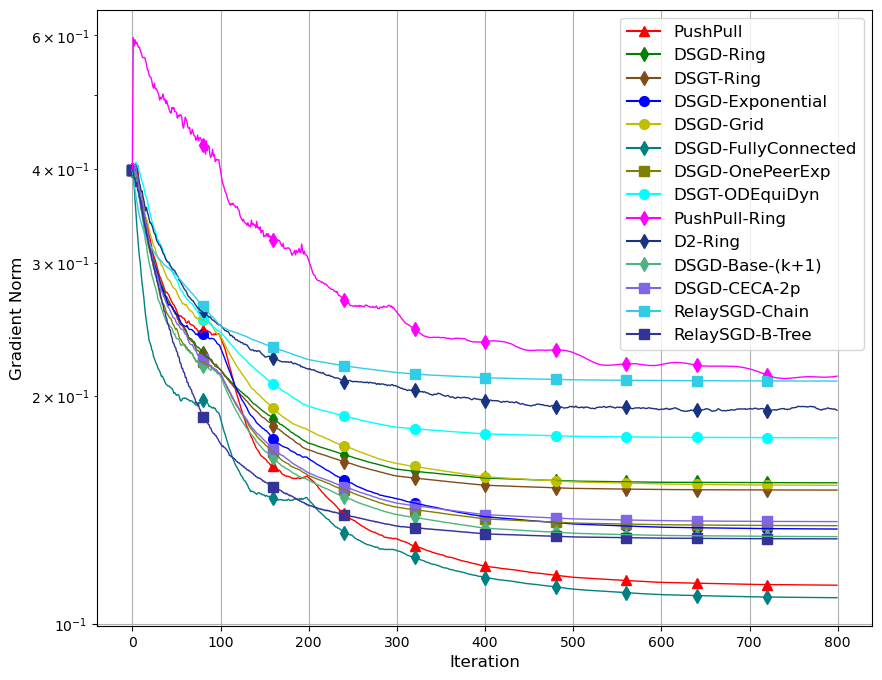

In [34]:
# plot the result
plt.rcParams['figure.figsize'] = 10, 8
plt.figure()

xlen = maxite

plt.semilogy(0, pushpull[0], color='red', marker='^', markersize = 7)
plt.semilogy(0, ring[0], color='green', marker='d', markersize = 7)
plt.semilogy(0, ring_gt[0], color = (0.5, 0.3, 0.1), marker='d', markersize = 7)
plt.semilogy(0, exp[0], color='blue', marker='o', markersize = 7)
# plt.semilogy(0, star[0], color='c', marker='^', markersize = 7)
plt.semilogy(0, grid[0], color='y', marker='o', markersize = 7)
plt.semilogy(0, full[0], color='teal', marker='d', markersize = 7)
plt.semilogy(0, onepeerexp[0], color='olive', marker='s', markersize = 7)
plt.semilogy(0, ODEqui[0], color='cyan', marker='o', markersize = 7)
plt.semilogy(0, pushpull_ring[0], color = 'magenta', marker = 'd', markersize = 7)
plt.semilogy(0, D2_ring[0], color = (0.1, 0.2, 0.5), marker = 'd', markersize = 7)
plt.semilogy(0, basek[0], color = (0.3, 0.7, 0.5), marker = 'd', markersize = 7)
plt.semilogy(0, dsgd_ceca[0], color = (0.5, 0.4, 0.9), marker = 's', markersize = 7)
plt.semilogy(0, relaysgd_chain[0], color = (0.2, 0.8, 0.9), marker = 's', markersize = 7)
plt.semilogy(0, relaysgd_binarytree[0], color = (0.2, 0.2, 0.6), marker = 's', markersize = 7)

idx_set = np.arange(0, xlen, xlen//10)

plt.semilogy(idx_set, pushpull[idx_set], color='red', marker='^', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, ring[idx_set], color='green', marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, ring_gt[idx_set], color=(0.5, 0.3, 0.1), marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, exp[idx_set], color='blue', marker='o', markersize = 7, linestyle = 'None')
# plt.semilogy(idx_set, star[idx_set], color='c', marker='^', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, grid[idx_set], color='y', marker='o', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, full[idx_set], color='teal', marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, onepeerexp[idx_set], color='olive', marker='s', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, ODEqui[idx_set], color='cyan', marker='o', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, pushpull_ring[idx_set], color='magenta', marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, D2_ring[idx_set], color=(0.1, 0.2, 0.5), marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, basek[idx_set], color=(0.3, 0.7, 0.5), marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, dsgd_ceca[idx_set], color=(0.5, 0.4, 0.9), marker='s', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, relaysgd_chain[idx_set], color=(0.2, 0.8, 0.9), marker='s', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, relaysgd_binarytree[idx_set], color=(0.2, 0.2, 0.6), marker='s', markersize = 7, linestyle = 'None')


plt.semilogy(np.arange(xlen), pushpull, linewidth=1.0, color='red')
plt.semilogy(np.arange(xlen), ring, linewidth=1.0, color='green')
plt.semilogy(np.arange(xlen), ring_gt, linewidth=1.0, color=(0.5, 0.3, 0.1))
plt.semilogy(np.arange(xlen), exp, linewidth=1.0, color='blue')
# plt.semilogy(np.arange(xlen), star, linewidth=1.0, color='c')
plt.semilogy(np.arange(xlen), grid, linewidth=1.0, color='y')
plt.semilogy(np.arange(xlen), full, linewidth=1.0, color='teal')
plt.semilogy(np.arange(xlen), onepeerexp, linewidth=1.0, color='olive')
plt.semilogy(np.arange(xlen), ODEqui, linewidth=1.0, color='cyan')
plt.semilogy(np.arange(xlen), pushpull_ring, linewidth=1.0, color='magenta')
plt.semilogy(np.arange(xlen), D2_ring, linewidth=1.0, color=(0.1, 0.2, 0.5))
plt.semilogy(np.arange(xlen), basek, linewidth=1.0, color=(0.3, 0.7, 0.5))
plt.semilogy(np.arange(xlen), dsgd_ceca, linewidth=1.0, color=(0.5, 0.4, 0.9))
plt.semilogy(np.arange(xlen), relaysgd_chain, linewidth=1.0, color=(0.2, 0.8, 0.9))
plt.semilogy(np.arange(xlen), relaysgd_binarytree, linewidth=1.0, color=(0.2, 0.2, 0.6))

plt.legend([
            'PushPull',
            'DSGD-Ring',
            'DSGT-Ring',
            'DSGD-Exponential',
            # 'Star',
            'DSGD-Grid',
            'DSGD-FullyConnected',
            'DSGD-OnePeerExp',
            'DSGT-ODEquiDyn',
            'PushPull-Ring',
            'D2-Ring',
            'DSGD-Base-(k+1)',
            'DSGD-CECA-2p',
            'RelaySGD-Chain',
            'RelaySGD-B-Tree'
           ], fontsize=12, loc = 'upper right')
plt.xlabel('Iteration', fontsize = 12)
plt.ylabel('Gradient Norm', fontsize = 12)
# plt.title('Distributed Method')
plt.grid(True)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.show()
plt.savefig("decentralizedmethod.png")

#### Problem. Plot the $\mathcal{O}(1)$ graph 

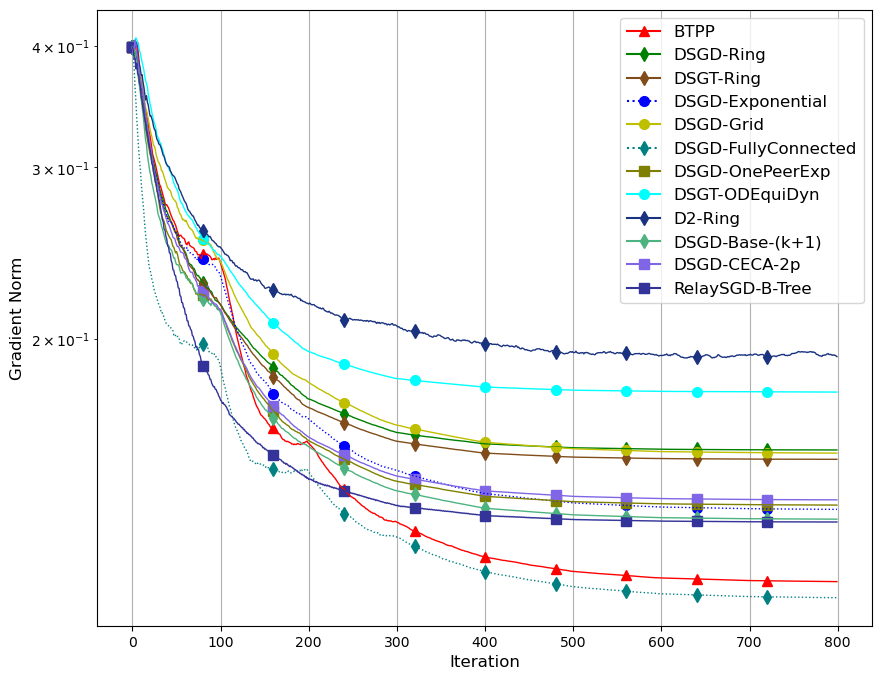

In [35]:
# plot the result
plt.rcParams['figure.figsize'] = 10, 8
plt.figure()

xlen = maxite

plt.semilogy(0, pushpull[0], color='red', marker='^', markersize = 7)
plt.semilogy(0, ring[0], color='green', marker='d', markersize = 7)
plt.semilogy(0, ring_gt[0], color = (0.5, 0.3, 0.1), marker='d', markersize = 7)
plt.semilogy(0, exp[0], color='blue', marker='o', markersize = 7, linestyle = 'dotted')
# plt.semilogy(0, star[0], color='c', marker='^', markersize = 7)
plt.semilogy(0, grid[0], color='y', marker='o', markersize = 7)
plt.semilogy(0, full[0], color='teal', marker='d', markersize = 7, linestyle = 'dotted')
plt.semilogy(0, onepeerexp[0], color='olive', marker='s', markersize = 7)
plt.semilogy(0, ODEqui[0], color='cyan', marker='o', markersize = 7)
# plt.semilogy(0, pushpull_ring[0], color = 'magenta', marker = 'd', markersize = 7)
plt.semilogy(0, D2_ring[0], color = (0.1, 0.2, 0.5), marker = 'd', markersize = 7)
plt.semilogy(0, basek[0], color = (0.3, 0.7, 0.5), marker = 'd', markersize = 7)
plt.semilogy(0, dsgd_ceca[0], color = (0.5, 0.4, 0.9), marker = 's', markersize = 7)
# plt.semilogy(0, relaysgd_chain[0], color = (0.2, 0.8, 0.9), marker = 's', markersize = 7)
plt.semilogy(0, relaysgd_binarytree[0], color = (0.2, 0.2, 0.6), marker = 's', markersize = 7)

idx_set = np.arange(0, xlen, xlen//10)

plt.semilogy(idx_set, pushpull[idx_set], color='red', marker='^', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, ring[idx_set], color='green', marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, ring_gt[idx_set], color=(0.5, 0.3, 0.1), marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, exp[idx_set], color='blue', marker='o', markersize = 7, linestyle = 'None')
# plt.semilogy(idx_set, star[idx_set], color='c', marker='^', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, grid[idx_set], color='y', marker='o', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, full[idx_set], color='teal', marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, onepeerexp[idx_set], color='olive', marker='s', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, ODEqui[idx_set], color='cyan', marker='o', markersize = 7, linestyle = 'None')
# plt.semilogy(idx_set, pushpull_ring[idx_set], color='magenta', marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, D2_ring[idx_set], color=(0.1, 0.2, 0.5), marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, basek[idx_set], color=(0.3, 0.7, 0.5), marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, dsgd_ceca[idx_set], color=(0.5, 0.4, 0.9), marker='s', markersize = 7, linestyle = 'None')
# plt.semilogy(idx_set, relaysgd_chain[idx_set], color=(0.2, 0.8, 0.9), marker='s', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, relaysgd_binarytree[idx_set], color=(0.2, 0.2, 0.6), marker='s', markersize = 7, linestyle = 'None')

plt.semilogy(np.arange(xlen), pushpull, linewidth=1.0, color='red')
plt.semilogy(np.arange(xlen), ring, linewidth=1.0, color='green')
plt.semilogy(np.arange(xlen), ring_gt, linewidth=1.0, color=(0.5, 0.3, 0.1))
plt.semilogy(np.arange(xlen), exp, linewidth=1.0, color='blue', linestyle = 'dotted')
# plt.semilogy(np.arange(xlen), star, linewidth=1.0, color='c')
plt.semilogy(np.arange(xlen), grid, linewidth=1.0, color='y')
plt.semilogy(np.arange(xlen), full, linewidth=1.0, color='teal', linestyle = 'dotted')
plt.semilogy(np.arange(xlen), onepeerexp, linewidth=1.0, color='olive')
plt.semilogy(np.arange(xlen), ODEqui, linewidth=1.0, color='cyan')
# plt.semilogy(np.arange(xlen), pushpull_ring, linewidth=1.0, color='magenta')
plt.semilogy(np.arange(xlen), D2_ring, linewidth=1.0, color=(0.1, 0.2, 0.5))
plt.semilogy(np.arange(xlen), basek, linewidth=1.0, color=(0.3, 0.7, 0.5))
plt.semilogy(np.arange(xlen), dsgd_ceca, linewidth=1.0, color=(0.5, 0.4, 0.9))
# plt.semilogy(np.arange(xlen), relaysgd_chain, linewidth=1.0, color=(0.2, 0.8, 0.9))
plt.semilogy(np.arange(xlen), relaysgd_binarytree, linewidth=1.0, color=(0.2, 0.2, 0.6))

plt.legend([
            'BTPP',
            'DSGD-Ring',
            'DSGT-Ring',
            'DSGD-Exponential',
            # 'Star',
            'DSGD-Grid',
            'DSGD-FullyConnected',
            'DSGD-OnePeerExp',
            'DSGT-ODEquiDyn',
            # 'PushPull-Ring',
            'D2-Ring',
            'DSGD-Base-(k+1)',
            'DSGD-CECA-2p',
            # 'RelaySGD-Chain',
            'RelaySGD-B-Tree'
           ], fontsize=12, loc = 'upper right')
plt.xlabel('Iteration', fontsize = 12)
plt.ylabel('Gradient Norm', fontsize = 12)
# plt.title('Distributed Method')
plt.grid(True)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.show()
plt.savefig("decentralizedmethod.png")

#### Problem. Influence on Branch Size 

In [36]:
pushpull_B2 = np.zeros((maxite,1))
pushpull_B3 = np.zeros((maxite,1))
pushpull_B4 = np.zeros((maxite,1))
pushpull_B8 = np.zeros((maxite,1))
pushpull_B16 = np.zeros((maxite,1))
pushpull_B32 = np.zeros((maxite,1))
pushpull_B64 = np.zeros((maxite,1))
pushpull_B100 = np.zeros((maxite,1))
for i in range(exp_repeat):
    print("training start!")
    seed0 = i*seed
    pushpull_B2 += train_pp(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,  
                         seed0 = seed0,  period = period, B = 2, batch = 1, method = 'BTPP')
    pushpull_B3 += train_pp(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,  
                         seed0 = seed0,  period = period, B = 3, batch = 1, method = 'BTPP')
    pushpull_B4 += train_pp(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,  
                         seed0 = seed0,  period = period, B = 4, batch = 1, method = 'BTPP')
    pushpull_B8 += train_pp(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,  
                         seed0 = seed0,  period = period, B = 8, batch = 1, method = 'BTPP')
    pushpull_B16 += train_pp(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,  
                         seed0 = seed0,  period = period, B = 16, batch = 1, method = 'BTPP')
    pushpull_B32 += train_pp(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,  
                         seed0 = seed0,  period = period, B = 32, batch = 1, method = 'BTPP')
    pushpull_B64 += train_pp(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,  
                         seed0 = seed0,  period = period, B = 64, batch = 1, method = 'BTPP')
    pushpull_B100 += train_pp(n = n, d = d, R = R, X = X, y = y, maxite = maxite, mu = mu,  
                         seed0 = seed0,  period = period, B = 100, batch = 1, method = 'BTPP')

training start!
training start!
training start!
training start!
training start!


In [37]:
pushpull_B2 = pushpull_B2/exp_repeat
pushpull_B3 = pushpull_B3/exp_repeat
pushpull_B4 = pushpull_B4/exp_repeat
pushpull_B8 = pushpull_B8/exp_repeat
pushpull_B16 = pushpull_B16/exp_repeat
pushpull_B32 = pushpull_B32/exp_repeat
pushpull_B64 = pushpull_B64/exp_repeat
pushpull_B100 = pushpull_B100/exp_repeat

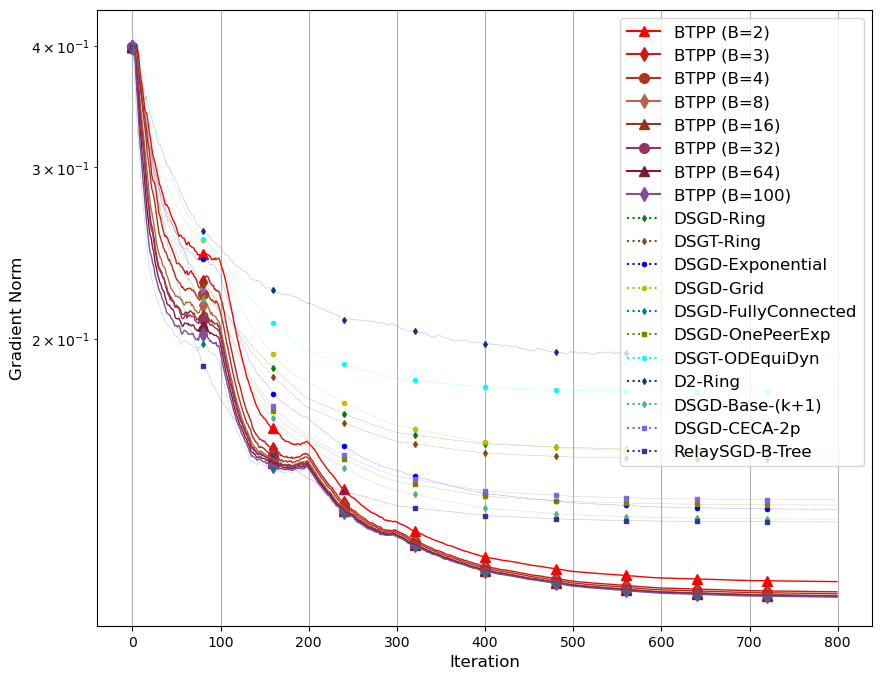

In [38]:
# plot the result
plt.rcParams['figure.figsize'] = 10, 8
plt.figure()

xlen = maxite

plt.semilogy(0, pushpull_B2[0], color='red', marker='^', markersize = 7)
plt.semilogy(0, pushpull_B3[0], color=(0.8, 0.1, 0.1), marker='d', markersize = 7)
plt.semilogy(0, pushpull_B4[0], color=(0.7, 0.2, 0.1), marker='o', markersize = 7)
plt.semilogy(0, pushpull_B8[0], color=(0.7, 0.4, 0.3), marker='d', markersize = 7)
plt.semilogy(0, pushpull_B16[0], color=(0.6, 0.2, 0.1), marker='^', markersize = 7)
plt.semilogy(0, pushpull_B32[0], color=(0.6, 0.2, 0.4), marker='o', markersize = 7)
plt.semilogy(0, pushpull_B64[0], color=(0.5, 0.1, 0.2), marker='^', markersize = 7)
plt.semilogy(0, pushpull_B100[0], color=(0.5, 0.3, 0.6), marker='d', markersize = 7)

plt.semilogy(0, ring[0], color='green', marker='d', markersize = 3, linestyle = 'dotted')
plt.semilogy(0, ring_gt[0], color = (0.5, 0.3, 0.1), marker='d', markersize = 3, linestyle = 'dotted')
plt.semilogy(0, exp[0], color='blue', marker='o', markersize = 3, linestyle = 'dotted')
# plt.semilogy(0, star[0], color='c', marker='^', markersize = 7, linestyle = 'dotted')
plt.semilogy(0, grid[0], color='y', marker='o', markersize = 3, linestyle = 'dotted')
plt.semilogy(0, full[0], color='teal', marker='d', markersize = 3, linestyle = 'dotted')
plt.semilogy(0, onepeerexp[0], color='olive', marker='s', markersize = 3, linestyle = 'dotted')
plt.semilogy(0, ODEqui[0], color='cyan', marker='o', markersize = 3, linestyle = 'dotted')
# plt.semilogy(0, pushpull_ring[0], color = 'magenta', marker = 'd', markersize = 7)
plt.semilogy(0, D2_ring[0], color = (0.1, 0.2, 0.5), marker = 'd', markersize = 3, linestyle = 'dotted')
plt.semilogy(0, basek[0], color = (0.3, 0.7, 0.5), marker = 'd', markersize = 3, linestyle = 'dotted')
plt.semilogy(0, dsgd_ceca[0], color = (0.5, 0.4, 0.9), marker = 's', markersize = 3, linestyle = 'dotted')
# plt.semilogy(0, relaysgd_chain[0], color = (0.2, 0.8, 0.9), marker = 's', markersize = 7)
plt.semilogy(0, relaysgd_binarytree[0], color = (0.2, 0.2, 0.6), marker = 's', markersize = 3, linestyle = 'dotted')

idx_set = np.arange(0, xlen, xlen//10)

plt.semilogy(idx_set, pushpull_B2[idx_set], color='red', marker='^', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, pushpull_B3[idx_set], color=(0.8, 0.1, 0.1), marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, pushpull_B4[idx_set], color=(0.7, 0.2, 0.1), marker='o', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, pushpull_B8[idx_set], color=(0.7, 0.4, 0.3), marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, pushpull_B16[idx_set], color=(0.6, 0.2, 0.1), marker='^', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, pushpull_B32[idx_set], color=(0.6, 0.2, 0.4), marker='o', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, pushpull_B64[idx_set], color=(0.5, 0.1, 0.2), marker='^', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, pushpull_B100[idx_set], color=(0.5, 0.3, 0.6), marker='d', markersize = 7, linestyle = 'None')


plt.semilogy(idx_set, ring[idx_set], color='green', marker='d', markersize = 3, linestyle = 'None')
plt.semilogy(idx_set, ring_gt[idx_set], color=(0.5, 0.3, 0.1), marker='d', markersize = 3, linestyle = 'None')
plt.semilogy(idx_set, exp[idx_set], color='blue', marker='o', markersize = 3, linestyle = 'None')
# plt.semilogy(idx_set, star[idx_set], color='c', marker='^', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, grid[idx_set], color='y', marker='o', markersize = 3, linestyle = 'None')
plt.semilogy(idx_set, full[idx_set], color='teal', marker='d', markersize = 3, linestyle = 'None')
plt.semilogy(idx_set, onepeerexp[idx_set], color='olive', marker='s', markersize = 3, linestyle = 'None')
plt.semilogy(idx_set, ODEqui[idx_set], color='cyan', marker='o', markersize = 3, linestyle = 'None')
# plt.semilogy(idx_set, pushpull_ring[idx_set], color='magenta', marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, D2_ring[idx_set], color=(0.1, 0.2, 0.5), marker='d', markersize = 3, linestyle = 'None')
plt.semilogy(idx_set, basek[idx_set], color=(0.3, 0.7, 0.5), marker='d', markersize = 3, linestyle = 'None')
plt.semilogy(idx_set, dsgd_ceca[idx_set], color=(0.5, 0.4, 0.9), marker='s', markersize = 3, linestyle = 'None')
# plt.semilogy(idx_set, relaysgd_chain[idx_set], color=(0.2, 0.8, 0.9), marker='s', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, relaysgd_binarytree[idx_set], color=(0.2, 0.2, 0.6), marker='s', markersize = 3, linestyle = 'None')



plt.semilogy(np.arange(xlen), pushpull_B2, linewidth=1.0, color='red')
plt.semilogy(np.arange(xlen), pushpull_B3, linewidth=1.0, color=(0.8, 0.1, 0.1))
plt.semilogy(np.arange(xlen), pushpull_B4, linewidth=1.0, color=(0.7, 0.2, 0.1))
plt.semilogy(np.arange(xlen), pushpull_B8, linewidth=1.0, color=(0.7, 0.4, 0.3))
plt.semilogy(np.arange(xlen), pushpull_B16, linewidth=1.0, color=(0.6, 0.2, 0.1))
plt.semilogy(np.arange(xlen), pushpull_B32, linewidth=1.0, color=(0.6, 0.2, 0.4))
plt.semilogy(np.arange(xlen), pushpull_B64, linewidth=1.0, color=(0.5, 0.1, 0.2))
plt.semilogy(np.arange(xlen), pushpull_B100, linewidth=1.0, color=(0.5, 0.3, 0.6))

plt.semilogy(np.arange(xlen), ring, linewidth=0.3, color='green', linestyle = 'dotted')
plt.semilogy(np.arange(xlen), ring_gt, linewidth=0.3, color=(0.5, 0.3, 0.1), linestyle = 'dotted')
plt.semilogy(np.arange(xlen), exp, linewidth=0.3, color='blue', linestyle = 'dotted')
# plt.semilogy(np.arange(xlen), star, linewidth=1.0, color='c')
plt.semilogy(np.arange(xlen), grid, linewidth=0.3, color='y', linestyle = 'dotted')
plt.semilogy(np.arange(xlen), full, linewidth=0.3, color='teal', linestyle = 'dotted')
plt.semilogy(np.arange(xlen), onepeerexp, linewidth=0.3, color='olive', linestyle = 'dotted')
plt.semilogy(np.arange(xlen), ODEqui, linewidth=0.3, color='cyan', linestyle = 'dotted')
# plt.semilogy(np.arange(xlen), pushpull_ring, linewidth=1.0, color='magenta')
plt.semilogy(np.arange(xlen), D2_ring, linewidth=0.3, color=(0.1, 0.2, 0.5), linestyle = 'dotted')
plt.semilogy(np.arange(xlen), basek, linewidth=0.3, color=(0.3, 0.7, 0.5), linestyle = 'dotted')
plt.semilogy(np.arange(xlen), dsgd_ceca, linewidth=0.3, color=(0.5, 0.4, 0.9), linestyle = 'dotted')
# plt.semilogy(np.arange(xlen), relaysgd_chain, linewidth=1.0, color=(0.2, 0.8, 0.9))
plt.semilogy(np.arange(xlen), relaysgd_binarytree, linewidth=0.3, color=(0.2, 0.2, 0.6), linestyle = 'dotted')

plt.legend([
            'BTPP (B=2)',
            'BTPP (B=3)',
            'BTPP (B=4)',
            'BTPP (B=8)',
           'BTPP (B=16)',
           'BTPP (B=32)',
           'BTPP (B=64)',
           'BTPP (B=100)',
            'DSGD-Ring',
            'DSGT-Ring',
            'DSGD-Exponential',
            # 'Star',
            'DSGD-Grid',
            'DSGD-FullyConnected',
            'DSGD-OnePeerExp',
            'DSGT-ODEquiDyn',
            # 'PushPull-Ring',
            'D2-Ring',
            'DSGD-Base-(k+1)',
            'DSGD-CECA-2p',
            # 'RelaySGD-Chain',
            'RelaySGD-B-Tree'
           ], fontsize=12, loc = 'upper right')
plt.xlabel('Iteration', fontsize = 12)
plt.ylabel('Gradient Norm', fontsize = 12)
# plt.title('Distributed Method')
plt.grid(True)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.show()
plt.savefig("BTPP.png")